In [1]:
# Notebook para obtener los resultados que se describen en esta página en kaggle.
#
# https://www.kaggle.com/code/azizozmen/heart-failure-predict-8-classification-techniques
#
# En Anaconda Navigator instalar previamente, con el gestor de entornos, instalar los siguientes paquetes:
# matplotlib, seaborn, scikit-learn, 
# Tiene las modificaciones necesarias para poder instalar las bibliotecas faltantes usando pip3 y pip.
# En la celda 6 se indica el nombre del archivo a procesar, en este caso se toma como referencia el que puso Miguel en la
# carpeta compartida en OneDrive, y es el de kaggle que tiene 12 atributos, se contempla que está en el subdirectorio
# datasets, creado en el mismo nivel donde está almacenado este notebook.

!pip3 install --upgrade setuptools
!pip3 install pyforest xgboost cufflinks colorama

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import scipy.stats as stats
import pyforest
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, OneHotEncoder, StandardScaler, PowerTransformer, MinMaxScaler, LabelEncoder, RobustScaler
from sklearn.model_selection import RepeatedStratifiedKFold, KFold, cross_val_predict, train_test_split, GridSearchCV, cross_val_score, cross_validate
from sklearn.linear_model import LinearRegression, Lasso, Ridge,ElasticNet
from sklearn.metrics import plot_confusion_matrix, r2_score, mean_absolute_error, mean_squared_error, classification_report, confusion_matrix, accuracy_score, classification_report
from sklearn.metrics import make_scorer, precision_score, precision_recall_curve, plot_precision_recall_curve, plot_roc_curve, roc_auc_score, roc_curve, f1_score, accuracy_score, recall_score
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingRegressor, ExtraTreesRegressor, AdaBoostClassifier
from sklearn.feature_selection import SelectKBest, SelectPercentile, f_classif, f_regression, mutual_info_regression
from xgboost import XGBRegressor, XGBClassifier
from xgboost import plot_importance
from sklearn.pipeline import Pipeline
from sklearn.tree import plot_tree
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

#importing plotly and cufflinks in offline mode
import cufflinks as cf
import plotly.offline
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)

import warnings
warnings.filterwarnings('ignore')
warnings.warn("this will not show")
plt.rcParams["figure.figsize"] = (10,6)
pd.set_option('max_colwidth',200)

# pd.set_option('display.max_rows', 100) # if you wish to see more rows rather than default, just uncomment this line.
pd.set_option('display.max_columns', 200)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

import colorama
from colorama import Fore, Style  # maakes strings colored
# !pip3 install termcolor
from termcolor import colored

/Users/giovanni/opt/anaconda3/envs/papercvd/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [3]:
# Function for determining the number and percentages of missing values

def missing (df):
    missing_number = df.isnull().sum().sort_values(ascending=False)
    missing_percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
    missing_values = pd.concat([missing_number, missing_percent], axis=1, keys=['Missing_Number', 'Missing_Percent'])
    return missing_values

In [4]:
# Function for insighting summary information about the column

def first_looking(col):
    print("column name    : ", col)
    print("--------------------------------")
    print("per_of_nulls   : ", "%", round(df[col].isnull().sum()/df.shape[0]*100, 2))
    print("num_of_nulls   : ", df[col].isnull().sum())
    print("num_of_uniques : ", df[col].nunique())
    print(df[col].value_counts(dropna = False))

In [5]:
# Function for examining scores

def train_val(y_train, y_train_pred, y_test, y_pred):
    scores = {"train_set": {"Accuracy" : accuracy_score(y_train, y_train_pred),
                            "Precision" : precision_score(y_train, y_train_pred),
                            "Recall" : recall_score(y_train, y_train_pred),                          
                            "f1" : f1_score(y_train, y_train_pred)},
    
              "test_set": {"Accuracy" : accuracy_score(y_test, y_pred),
                           "Precision" : precision_score(y_test, y_pred),
                           "Recall" : recall_score(y_test, y_pred),                          
                           "f1" : f1_score(y_test, y_pred)}}
    
    return pd.DataFrame(scores)

In [6]:
df0 = pd.read_csv("kaggle_4_datasets_12_atrib.csv")

In [7]:
df0

,age,sex,chest_pain_type,resting_bp,cholesterol,fasting_bs,resting_ecg,max_hr,exercise_angina,oldpeak,st_slope,heart_disease
0,40,M,ATA,140,289,0,Normal,172,N,0.000,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.000,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.000,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.500,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.000,Up,0
...,...,...,...,...,...,...,...,...,...,...,...,...
913,45,M,TA,110,264,0,Normal,132,N,1.200,Flat,1
914,68,M,ASY,144,193,1,Normal,141,N,3.400,Flat,1
915,57,M,ASY,130,131,0,Normal,115,Y,1.200,Flat,1
916,57,F,ATA,130,236,0,LVH,174,N,0.000,Flat,1


In [8]:
df = df0

In [9]:
df.head()

,age,sex,chest_pain_type,resting_bp,cholesterol,fasting_bs,resting_ecg,max_hr,exercise_angina,oldpeak,st_slope,heart_disease
0,40,M,ATA,140,289,0,Normal,172,N,0.000,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.000,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.000,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.500,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.000,Up,0


In [10]:
df.tail()

,age,sex,chest_pain_type,resting_bp,cholesterol,fasting_bs,resting_ecg,max_hr,exercise_angina,oldpeak,st_slope,heart_disease
913,45,M,TA,110,264,0,Normal,132,N,1.200,Flat,1
914,68,M,ASY,144,193,1,Normal,141,N,3.400,Flat,1
915,57,M,ASY,130,131,0,Normal,115,Y,1.200,Flat,1
916,57,F,ATA,130,236,0,LVH,174,N,0.000,Flat,1
917,38,M,NAP,138,175,0,Normal,173,N,0.000,Up,0


In [11]:
df.sample(10)

,age,sex,chest_pain_type,resting_bp,cholesterol,fasting_bs,resting_ecg,max_hr,exercise_angina,oldpeak,st_slope,heart_disease
575,56,M,ASY,137,282,1,Normal,126,Y,1.200,Flat,1
458,61,M,ASY,134,0,1,ST,86,N,1.500,Flat,1
52,45,M,ATA,140,224,1,Normal,122,N,0.000,Up,0
423,60,M,NAP,180,0,0,ST,140,Y,1.500,Flat,0
755,64,M,ASY,145,212,0,LVH,132,N,2.000,Flat,1
602,61,M,NAP,120,337,0,Normal,98,Y,0.000,Flat,1
495,64,F,ASY,142,276,0,Normal,140,Y,1.000,Flat,1
328,52,M,ASY,95,0,1,Normal,82,Y,0.800,Flat,1
260,46,M,ATA,140,275,0,Normal,165,Y,0.000,Up,0
781,50,F,ASY,110,254,0,LVH,159,N,0.000,Up,0


In [12]:
df.columns

Index(['age', 'sex', 'chest_pain_type', 'resting_bp', 'cholesterol',
       'fasting_bs', 'resting_ecg', 'max_hr', 'exercise_angina', 'oldpeak',
       'st_slope', 'heart_disease'],
      dtype='object')

In [13]:
print("There is", df.shape[0], "observation and", df.shape[1], "columns in the dataset")

There is 918 observation and 12 columns in the dataset


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   age              918 non-null    int64  
 1   sex              918 non-null    object 
 2   chest_pain_type  918 non-null    object 
 3   resting_bp       918 non-null    int64  
 4   cholesterol      918 non-null    int64  
 5   fasting_bs       918 non-null    int64  
 6   resting_ecg      918 non-null    object 
 7   max_hr           918 non-null    int64  
 8   exercise_angina  918 non-null    object 
 9   oldpeak          918 non-null    float64
 10  st_slope         918 non-null    object 
 11  heart_disease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


In [15]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
age,918.000,53.511,9.433,28.000,47.000,54.000,60.000,77.000
resting_bp,918.000,132.397,18.514,0.000,120.000,130.000,140.000,200.000
cholesterol,918.000,198.800,109.384,0.000,173.250,223.000,267.000,603.000
fasting_bs,918.000,0.233,0.423,0.000,0.000,0.000,0.000,1.000
max_hr,918.000,136.809,25.460,60.000,120.000,138.000,156.000,202.000
oldpeak,918.000,0.887,1.067,-2.600,0.000,0.600,1.500,6.200
heart_disease,918.000,0.553,0.497,0.000,0.000,1.000,1.000,1.000


In [16]:
df.describe(include=object).T

,count,unique,top,freq
sex,918,2,M,725
chest_pain_type,918,4,ASY,496
resting_ecg,918,3,Normal,552
exercise_angina,918,2,N,547
st_slope,918,3,Flat,460


In [17]:
df.nunique()

age                 50
sex                  2
chest_pain_type      4
resting_bp          67
cholesterol        222
fasting_bs           2
resting_ecg          3
max_hr             119
exercise_angina      2
oldpeak             53
st_slope             3
heart_disease        2
dtype: int64

In [18]:
# to find how many unique values object features have

for col in df.select_dtypes(include=[np.number]).columns:
  print(f"{col} has {df[col].nunique()} unique value")

age has 50 unique value
resting_bp has 67 unique value
cholesterol has 222 unique value
fasting_bs has 2 unique value
max_hr has 119 unique value
oldpeak has 53 unique value
heart_disease has 2 unique value


In [19]:
df.duplicated().value_counts()

False    918
dtype: int64

In [20]:
missing (df)

,Missing_Number,Missing_Percent
age,0,0.000
sex,0,0.000
chest_pain_type,0,0.000
resting_bp,0,0.000
cholesterol,0,0.000
fasting_bs,0,0.000
resting_ecg,0,0.000
max_hr,0,0.000
exercise_angina,0,0.000
oldpeak,0,0.000


In [21]:
first_looking("heart_disease")

column name    :  heart_disease
--------------------------------
per_of_nulls   :  % 0.0
num_of_nulls   :  0
num_of_uniques :  2
1    508
0    410
Name: heart_disease, dtype: int64


1    508
0    410
Name: heart_disease, dtype: int64


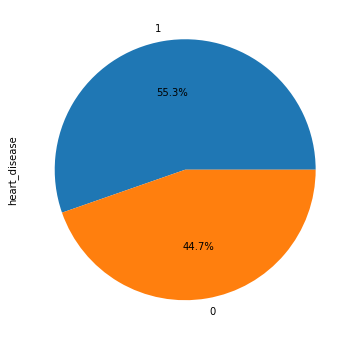

In [22]:
print(df["heart_disease"].value_counts())
df["heart_disease"].value_counts().plot(kind="pie", autopct='%1.1f%%', figsize=(6,6));

In [23]:
y = df['heart_disease']
print(f'Percentage of Heart Disease: % {round(y.value_counts(normalize=True)[1]*100,2)} --> \
({y.value_counts()[1]} cases for Heart Disease)\nPercentage of NOT Heart Disease: % {round(y.value_counts(normalize=True)[0]*100,2)} --> ({y.value_counts()[0]} cases for NOT Heart Disease)')

Percentage of Heart Disease: % 55.34 --> (508 cases for Heart Disease)
Percentage of NOT Heart Disease: % 44.66 --> (410 cases for NOT Heart Disease)


In [24]:
df['heart_disease'].describe()

count   918.000
mean      0.553
std       0.497
min       0.000
25%       0.000
50%       1.000
75%       1.000
max       1.000
Name: heart_disease, dtype: float64

In [25]:
df[df['heart_disease']==0].describe().T.style.background_gradient(subset=['mean','std','50%','count'], cmap='RdPu')

,count,mean,std,min,25%,50%,75%,max
age,410.000000,50.551220,9.444915,28.000000,43.000000,51.000000,57.000000,76.000000
resting_bp,410.000000,130.180488,16.499585,80.000000,120.000000,130.000000,140.000000,190.000000
cholesterol,410.000000,227.121951,74.634659,0.000000,197.250000,227.000000,266.750000,564.000000
fasting_bs,410.000000,0.107317,0.309894,0.000000,0.000000,0.000000,0.000000,1.000000
max_hr,410.000000,148.151220,23.288067,69.000000,134.000000,150.000000,165.000000,202.000000
oldpeak,410.000000,0.408049,0.699709,-1.100000,0.000000,0.000000,0.600000,4.200000
heart_disease,410.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [26]:
df[df['heart_disease']==1].describe().T.style.background_gradient(subset=['mean','std','50%','count'], cmap='RdPu')

,count,mean,std,min,25%,50%,75%,max
age,508.000000,55.899606,8.727056,31.000000,51.000000,57.000000,62.000000,77.000000
resting_bp,508.000000,134.185039,19.828685,0.000000,120.000000,132.000000,145.000000,200.000000
cholesterol,508.000000,175.940945,126.391398,0.000000,0.000000,217.000000,267.000000,603.000000
fasting_bs,508.000000,0.334646,0.472332,0.000000,0.000000,0.000000,1.000000,1.000000
max_hr,508.000000,127.655512,23.386923,60.000000,112.000000,126.000000,144.250000,195.000000
oldpeak,508.000000,1.274213,1.151872,-2.600000,0.000000,1.200000,2.000000,6.200000
heart_disease,508.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [27]:
print( f"Skewness: {df['heart_disease'].skew()}")

Skewness: -0.21508633825088655


In [28]:
print( f"Kurtosis: {df['heart_disease'].kurtosis()}")

Kurtosis: -1.9580084425329685


In [29]:
df['heart_disease'].iplot(kind='hist')

In [30]:
numerical= df.drop(['heart_disease'], axis=1).select_dtypes('number').columns

categorical = df.select_dtypes('object').columns

print(f'Numerical Columns:  {df[numerical].columns}')
print('\n')
print(f'Categorical Columns: {df[categorical].columns}')

Numerical Columns:  Index(['age', 'resting_bp', 'cholesterol', 'fasting_bs', 'max_hr', 'oldpeak'], dtype='object')


Categorical Columns: Index(['sex', 'chest_pain_type', 'resting_ecg', 'exercise_angina', 'st_slope'], dtype='object')


In [31]:
df[numerical].head().T

,0,1,2,3,4
age,40.000,49.000,37.000,48.000,54.000
resting_bp,140.000,160.000,130.000,138.000,150.000
cholesterol,289.000,180.000,283.000,214.000,195.000
fasting_bs,0.000,0.000,0.000,0.000,0.000
max_hr,172.000,156.000,98.000,108.000,122.000
oldpeak,0.000,1.000,0.000,1.500,0.000


In [32]:
df[numerical].describe().T

,count,mean,std,min,25%,50%,75%,max
age,918.000,53.511,9.433,28.000,47.000,54.000,60.000,77.000
resting_bp,918.000,132.397,18.514,0.000,120.000,130.000,140.000,200.000
cholesterol,918.000,198.800,109.384,0.000,173.250,223.000,267.000,603.000
fasting_bs,918.000,0.233,0.423,0.000,0.000,0.000,0.000,1.000
max_hr,918.000,136.809,25.460,60.000,120.000,138.000,156.000,202.000
oldpeak,918.000,0.887,1.067,-2.600,0.000,0.600,1.500,6.200


In [33]:
df[numerical].describe().T.style.background_gradient(subset=['mean','std','50%','count'], cmap='RdPu')

,count,mean,std,min,25%,50%,75%,max
age,918.000000,53.510893,9.432617,28.000000,47.000000,54.000000,60.000000,77.000000
resting_bp,918.000000,132.396514,18.514154,0.000000,120.000000,130.000000,140.000000,200.000000
cholesterol,918.000000,198.799564,109.384145,0.000000,173.250000,223.000000,267.000000,603.000000
fasting_bs,918.000000,0.233115,0.423046,0.000000,0.000000,0.000000,0.000000,1.000000
max_hr,918.000000,136.809368,25.460334,60.000000,120.000000,138.000000,156.000000,202.000000
oldpeak,918.000000,0.887364,1.066570,-2.600000,0.000000,0.600000,1.500000,6.200000


In [34]:
df[numerical].iplot(kind='hist');

In [35]:
df[numerical].iplot(kind='histogram', subplots=True,bins=50)

In [36]:
for i in numerical:
    df[i].iplot(kind="box", title=i, boxpoints="all", color='lightseagreen')

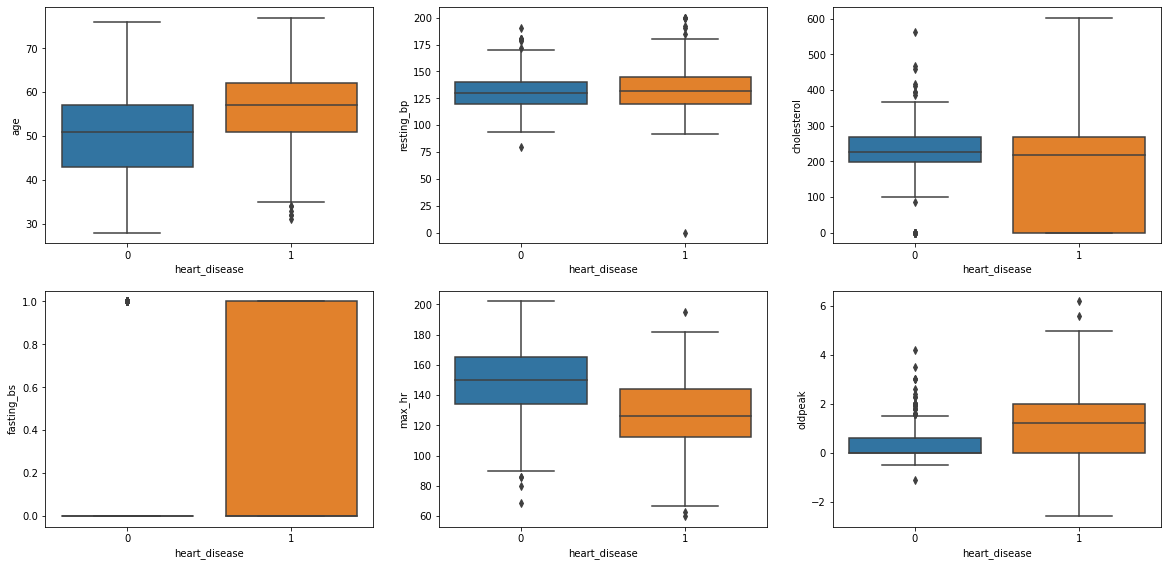

In [37]:
index = 0
plt.figure(figsize=(20,20))
for feature in numerical:
    if feature != "heart_disease":
        index += 1
        plt.subplot(4, 3, index)
        sns.boxplot(x='heart_disease', y=feature, data=df)

In [38]:
fig = px.scatter_3d(df, 
                    x='resting_bp',
                    y='age',
                    z='sex',
                    color='heart_disease')
fig.show();

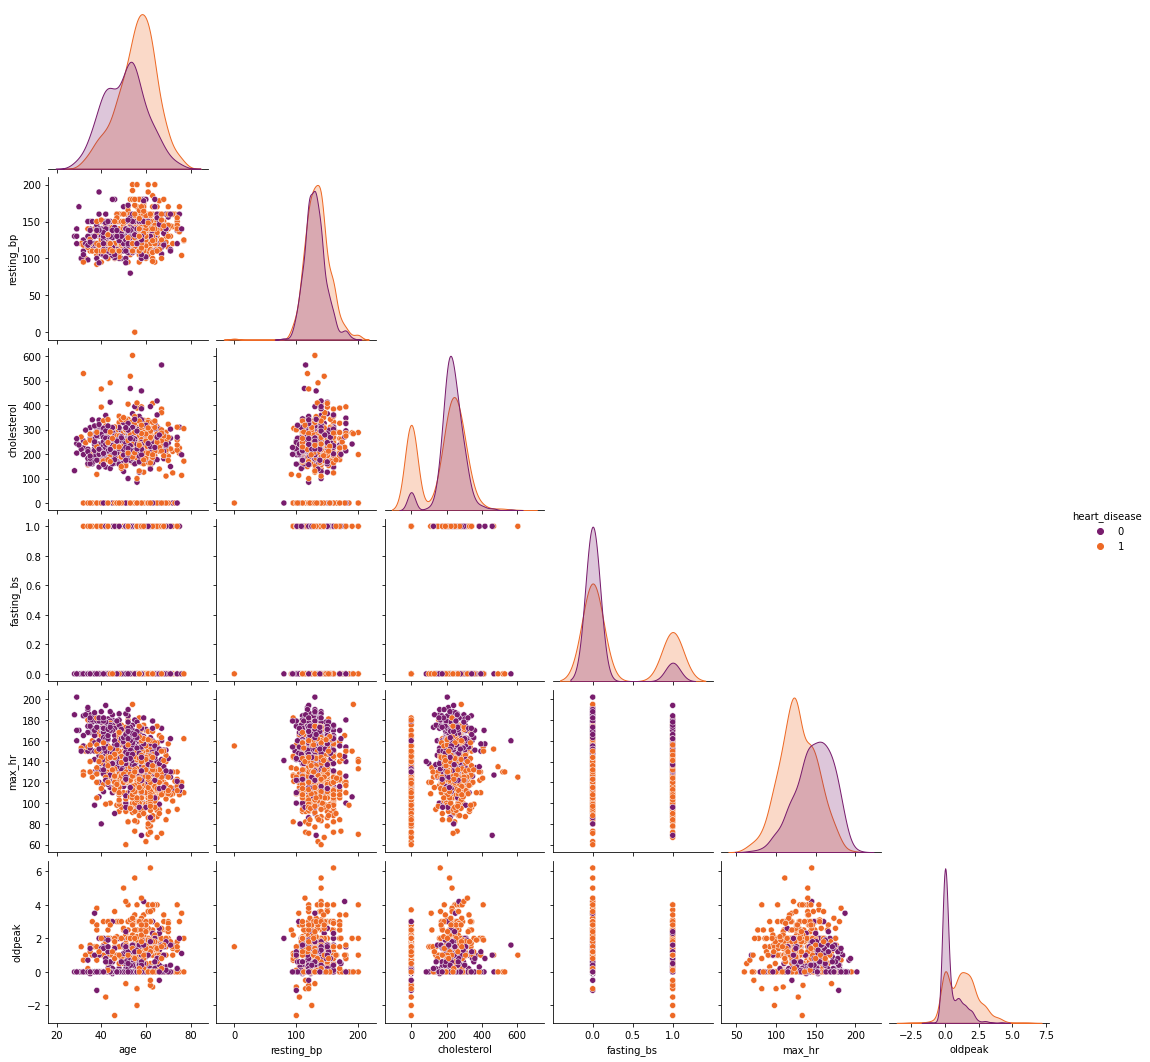

In [39]:
sns.pairplot(df, hue="heart_disease", palette="inferno", corner=True);

In [40]:
skew_vals = df.skew().sort_values(ascending=False)
skew_vals

fasting_bs       1.264
oldpeak          1.023
resting_bp       0.180
max_hr          -0.144
age             -0.196
heart_disease   -0.215
cholesterol     -0.610
dtype: float64

In [41]:
skew_limit = 0.5 # This is our threshold-limit to evaluate skewness. Overall below abs(1) seems acceptable for the linear models. 
skew_vals = df.skew()
skew_cols = skew_vals[abs(skew_vals)> skew_limit].sort_values(ascending=False)
skew_cols 

fasting_bs     1.264
oldpeak        1.023
cholesterol   -0.610
dtype: float64

In [42]:
#Interpreting Skewness 

for skew in skew_vals:
    if -0.5 < skew < 0.5:
        print ("A skewness value of", '\033[1m', Fore.GREEN, skew, '\033[0m', "means that the distribution is approx.", '\033[1m', Fore.GREEN, "symmetric", '\033[0m')
    elif  -0.5 < skew < -1.0 or 0.5 < skew < 1.0:
        print ("A skewness value of", '\033[1m', Fore.YELLOW, skew, '\033[0m', "means that the distribution is approx.", '\033[1m', Fore.YELLOW, "moderately skewed", '\033[0m')
    else:
        print ("A skewness value of", '\033[1m', Fore.RED, skew, '\033[0m', "means that the distribution is approx.", '\033[1m', Fore.RED, "highly skewed", '\033[0m')

A skewness value of   -0.19593302867569365  means that the distribution is approx.   symmetric 
A skewness value of   0.1798393100516288  means that the distribution is approx.   symmetric 
A skewness value of   -0.6100864307268192  means that the distribution is approx.   highly skewed 
A skewness value of   1.2644841750727027  means that the distribution is approx.   highly skewed 
A skewness value of   -0.14435941846180994  means that the distribution is approx.   symmetric 
A skewness value of   1.0228720218107528  means that the distribution is approx.   highly skewed 
A skewness value of   -0.21508633825088655  means that the distribution is approx.   symmetric 


In [43]:
kurtosis_vals = df.kurtosis().sort_values(ascending=False)
kurtosis_vals

resting_bp       3.271
oldpeak          1.203
cholesterol      0.118
age             -0.386
fasting_bs      -0.402
max_hr          -0.448
heart_disease   -1.958
dtype: float64

In [44]:
#Calculating Kurtosis 

kurtosis_limit = 7 # This is our threshold-limit to evaluate skewness. Overall below abs(1) seems acceptable for the linear models.
kurtosis_vals = df.kurtosis()
kurtosis_cols = kurtosis_vals[abs(kurtosis_vals) > kurtosis_limit].sort_values(ascending=False)
kurtosis_cols

Series([], dtype: float64)

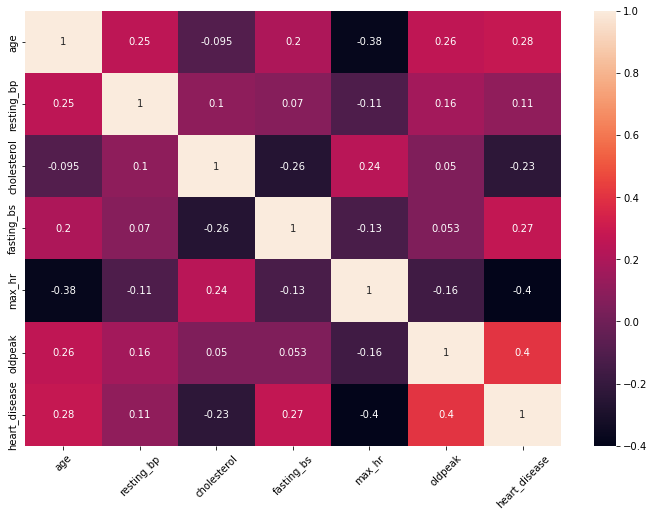

In [45]:
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(), annot=True)
plt.xticks(rotation=45);

In [46]:
df_temp = df.corr()

count = "Done"
feature =[]
collinear=[]
for col in df_temp.columns:
    for i in df_temp.index:
        if (df_temp[col][i]> .9 and df_temp[col][i] < 1) or (df_temp[col][i]< -.9 and df_temp[col][i] > -1) :
                feature.append(col)
                collinear.append(i)
                print(Fore.RED + f"\033[1mmulticolinearity alert in between\033[0m {col} - {i}")
        else:
            print(f"For {col} and {i}, there is NO multicollinearity problem") 

print("\033[1mThe number of strong corelated features:\033[0m", count) 

For age and age, there is NO multicollinearity problem
For age and resting_bp, there is NO multicollinearity problem
For age and cholesterol, there is NO multicollinearity problem
For age and fasting_bs, there is NO multicollinearity problem
For age and max_hr, there is NO multicollinearity problem
For age and oldpeak, there is NO multicollinearity problem
For age and heart_disease, there is NO multicollinearity problem
For resting_bp and age, there is NO multicollinearity problem
For resting_bp and resting_bp, there is NO multicollinearity problem
For resting_bp and cholesterol, there is NO multicollinearity problem
For resting_bp and fasting_bs, there is NO multicollinearity problem
For resting_bp and max_hr, there is NO multicollinearity problem
For resting_bp and oldpeak, there is NO multicollinearity problem
For resting_bp and heart_disease, there is NO multicollinearity problem
For cholesterol and age, there is NO multicollinearity problem
For cholesterol and resting_bp, there is

In [47]:
df[categorical].head().T

,0,1,2,3,4
sex,M,F,M,F,M
chest_pain_type,ATA,NAP,ATA,ASY,NAP
resting_ecg,Normal,Normal,ST,Normal,Normal
exercise_angina,N,N,N,Y,N
st_slope,Up,Flat,Up,Flat,Up


In [48]:
df[categorical].describe()

,sex,chest_pain_type,resting_ecg,exercise_angina,st_slope
count,918,918,918,918,918
unique,2,4,3,2,3
top,M,ASY,Normal,N,Flat
freq,725,496,552,547,460


In [49]:
for i in categorical:
    df[i].iplot(kind="box", title=i, boxpoints="all", color='lightseagreen')

In [50]:
df[categorical].iplot(kind='hist');

In [51]:
df[categorical].iplot(kind='histogram',subplots=True,bins=50)

In [52]:
df["sex"].value_counts()

M    725
F    193
Name: sex, dtype: int64

In [53]:
df['sex'].iplot(kind='hist', )

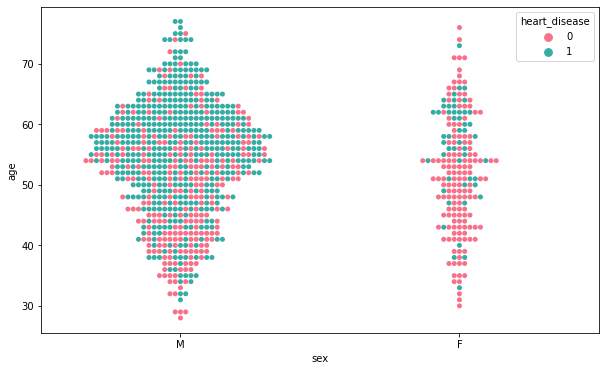

In [54]:
sns.swarmplot(y="age", x="sex", hue="heart_disease", data=df, palette="husl");

In [55]:
df["chest_pain_type"].value_counts()

ASY    496
NAP    203
ATA    173
TA      46
Name: chest_pain_type, dtype: int64

In [56]:
df['chest_pain_type'].iplot(kind='hist', )

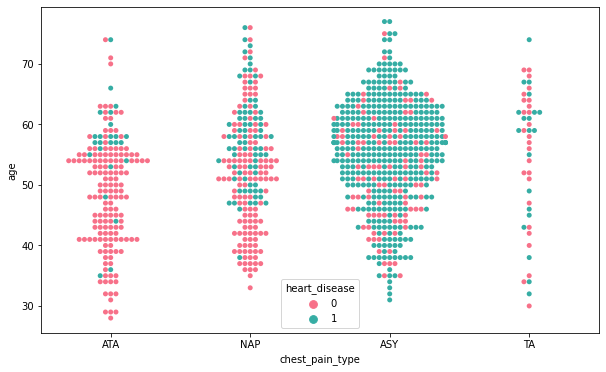

In [57]:
sns.swarmplot(y="age", x="chest_pain_type", hue="heart_disease", data=df, palette="husl");

In [58]:
df["resting_ecg"].value_counts()

Normal    552
LVH       188
ST        178
Name: resting_ecg, dtype: int64

In [59]:
df['resting_ecg'].iplot(kind='hist')

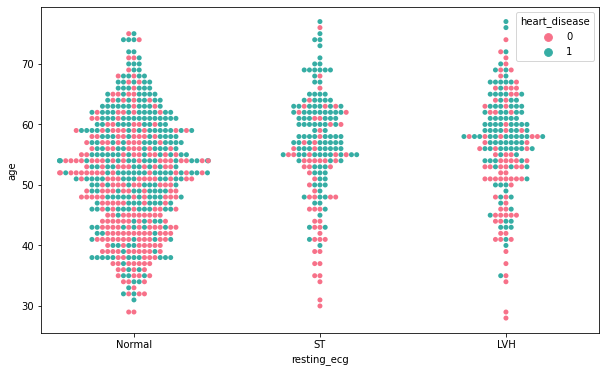

In [60]:
sns.swarmplot(y="age", x="resting_ecg", hue="heart_disease", data=df, palette="husl");

In [61]:
df["exercise_angina"].value_counts()

N    547
Y    371
Name: exercise_angina, dtype: int64

In [62]:
df['exercise_angina'].iplot(kind='hist')

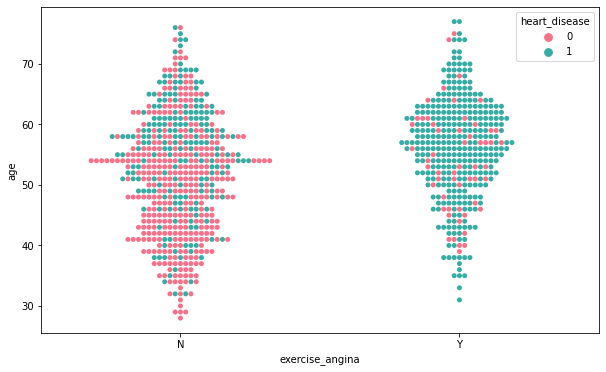

In [63]:
sns.swarmplot(y="age", x="exercise_angina", hue="heart_disease", data=df, palette="husl");

In [64]:
df["st_slope"].value_counts()

Flat    460
Up      395
Down     63
Name: st_slope, dtype: int64

In [65]:
df['st_slope'].iplot(kind='hist')

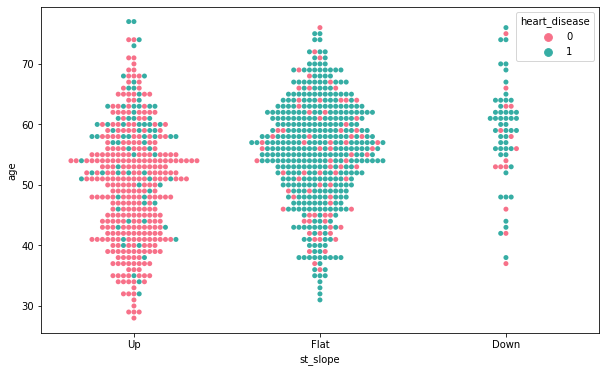

In [66]:
sns.swarmplot(y="age", x="st_slope", hue="heart_disease", data=df, palette="husl");

In [67]:
df.shape

(918, 12)

In [68]:
df.head()

,age,sex,chest_pain_type,resting_bp,cholesterol,fasting_bs,resting_ecg,max_hr,exercise_angina,oldpeak,st_slope,heart_disease
0,40,M,ATA,140,289,0,Normal,172,N,0.000,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.000,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.000,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.500,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.000,Up,0


In [69]:
df[categorical].value_counts()

sex  chest_pain_type  resting_ecg  exercise_angina  st_slope
M    ASY              Normal       Y                Flat        109
     ATA              Normal       N                Up           64
     ASY              Normal       N                Flat         55
                      ST           Y                Flat         49
     NAP              Normal       N                Up           46
                                                               ... 
F    NAP              ST           Y                Flat          1
     TA               LVH          N                Up            1
                      Normal       N                Down          1
M    ATA              LVH          Y                Flat          1
     TA               ST           Y                Flat          1
Length: 95, dtype: int64

In [70]:
df = pd.get_dummies(df, drop_first=True)

In [71]:
df.shape

(918, 16)

In [72]:
df.head()

,age,resting_bp,cholesterol,fasting_bs,max_hr,oldpeak,heart_disease,sex_M,chest_pain_type_ATA,chest_pain_type_NAP,chest_pain_type_TA,resting_ecg_Normal,resting_ecg_ST,exercise_angina_Y,st_slope_Flat,st_slope_Up
0,40,140,289,0,172,0.000,0,1,1,0,0,1,0,0,0,1
1,49,160,180,0,156,1.000,1,0,0,1,0,1,0,0,1,0
2,37,130,283,0,98,0.000,0,1,1,0,0,0,1,0,0,1
3,48,138,214,0,108,1.500,1,0,0,0,0,1,0,1,1,0
4,54,150,195,0,122,0.000,0,1,0,1,0,1,0,0,0,1


In [73]:
X = df.drop(["heart_disease"], axis=1)
y = df["heart_disease"]

In [74]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, stratify = y, random_state = 101)

In [75]:
missing(df)

,Missing_Number,Missing_Percent
age,0,0.000
resting_bp,0,0.000
cholesterol,0,0.000
fasting_bs,0,0.000
max_hr,0,0.000
oldpeak,0,0.000
heart_disease,0,0.000
sex_M,0,0.000
chest_pain_type_ATA,0,0.000
chest_pain_type_NAP,0,0.000


In [76]:
scaler = MinMaxScaler()
scaler

MinMaxScaler()

In [77]:
X_train_scaled = scaler.fit_transform(X_train)

In [78]:
X_test_scaled = scaler.transform(X_test)

In [79]:
# General Insights

def model_first_insight(X_train, y_train, class_weight, solver='liblinear'):
    # Logistic Regression
    log = LogisticRegression(random_state=101, class_weight=class_weight)
    log.fit(X_train, y_train)
    
    # Decision Tree
    decision_tree = DecisionTreeClassifier(criterion = 'entropy', random_state=101, class_weight=class_weight)
    decision_tree.fit(X_train, y_train)
   
    # Random Forest
    random_forest = RandomForestClassifier(n_estimators=10, criterion = 'entropy', random_state=101, class_weight=class_weight)
    random_forest.fit(X_train, y_train)
    
    # KNN
    knn = KNeighborsClassifier(n_neighbors = 3)
    knn.fit(X_train, y_train) 
   
    # SVC
    svc = SVC(random_state=101, class_weight=class_weight)
    svc.fit(X_train, y_train) 
    
    # XGB
    xgb = XGBClassifier(random_state=101, class_weight=class_weight)
    xgb.fit(X_train, y_train)
    
    # AdaBoosting
    ab = AdaBoostClassifier(n_estimators=50, random_state=101)
    ab.fit(X_train, y_train)
    
    # GB GradientBoosting
    gb = GradientBoostingClassifier(random_state=101)
    gb.fit(X_train, y_train)
    
    # Model Accuracy on Training Data
    print(f"\033[1m1) Logistic Regression Training Accuracy:\033[0m {log.score(X_train, y_train)}")
    print(f"\033[1m2) SVC Training Accuracy:\033[0m {svc.score(X_train, y_train)}")    
    print(f"\033[1m3) Decision Tree Training Accuracy:\033[0m {decision_tree.score(X_train, y_train)}")
    print(f"\033[1m4) Random Forest Training Accuracy:\033[0m {random_forest.score(X_train, y_train)}")
    print(f"\033[1m5) KNN Training Accuracy:\033[0m {knn.score(X_train, y_train)}")
    print(f"\033[1m6) GradiendBoosting Training Accuracy:\033[0m {gb.score(X_train, y_train)}")
    print(f"\033[1m7) AdaBoosting Training Accuracy:\033[0m {ab.score(X_train, y_train)}")
    print(f"\033[1m8) XGBoosting Training Accuracy:\033[0m {xgb.score(X_train, y_train)}")
    
    return log, svc, decision_tree, random_forest, knn, gb, ab, xgb

In [80]:
def models(X_train, y_train, class_weight):
    
    # Logistic Regression
    log = LogisticRegression(random_state=101, class_weight=class_weight, solver='liblinear')
    log.fit(X_train, y_train)
    
    # Decision Tree
    decision_tree = DecisionTreeClassifier(criterion = 'entropy', random_state=101, class_weight=class_weight)
    decision_tree.fit(X_train, y_train)
    
    # Random Forest
    random_forest = RandomForestClassifier(n_estimators=10, criterion = 'entropy', random_state=101, class_weight=class_weight)
    random_forest.fit(X_train, y_train)
    # KNN
    knn = KNeighborsClassifier(n_neighbors = 3)
    knn.fit(X_train, y_train) 
   
    # SVC
    svc = SVC(random_state=101, class_weight=class_weight)
    svc.fit(X_train, y_train) 
    
    # XGB
    xgb = XGBClassifier(random_state=101, class_weight=class_weight)
    xgb.fit(X_train, y_train)
    
    # AdaBoosting
    ab = AdaBoostClassifier(n_estimators=50, random_state=101)
    ab.fit(X_train, y_train)
    
    # GB GradientBoosting
    gb = GradientBoostingClassifier(random_state=101)
    gb.fit(X_train, y_train)
    
    # Model Accuracy on Training Data
    print(f"\033[1m1) Logistic Regression Training Accuracy:\033[0m {log}")
    print(f"\033[1m2) SVC Training Accuracy:\033[0m {svc}")    
    print(f"\033[1m3) Decision Tree Training Accuracy:\033[0m {decision_tree}")
    print(f"\033[1m4) Random Forest Training Accuracy:\033[0m {random_forest}")
    print(f"\033[1m5) KNN Training Accuracy:\033[0m {knn}")
    print(f"\033[1m6) GradiendBoosting Training Accuracy:\033[0m {gb}")
    print(f"\033[1m7) AdaBoosting Training Accuracy:\033[0m {ab}")
    print(f"\033[1m8) XGBoosting Training Accuracy:\033[0m {xgb}")
  
    return log.score(X_train, y_train), svc.score(X_train, y_train),decision_tree.score(X_train, y_train),random_forest.score(X_train, y_train),knn.score(X_train, y_train),gb.score(X_train, y_train),ab.score(X_train, y_train),xgb.score(X_train, y_train)

In [81]:
def models_accuracy(X_Set, y_Set):    
    Scores = pd.DataFrame(columns = ["LR_Acc", "SVC_Acc", "DT_Acc", "RF_Acc", "KNN_Acc", "GB_Acc", "AB_Acc", "XGB_Acc"])

    print("\033[1mBASIC ACCURACY\033[0m")
    Basic = [log_acc, svc_acc, decision_tree_acc, random_forest_acc, knn_acc, gb_acc, ab_acc, xgb_acc] = models(X_train, y_train, None)
    Scores.loc[0] = Basic

    print("\n\033[1mSCALED ACCURACY WITHOUT BALANCED\033[0m")    
    Scaled = [log_acc, svc_acc, decision_tree_acc, random_forest_acc, knn_acc, gb_acc, ab_acc, xgb_acc] = models(X_train_scaled, y_train, None)
    Scores.loc[1] = Scaled

    
    print("\n\033[1mBASIC ACCURACY WITH BALANCED\033[0m")
    Balanced = [log_acc, svc_acc, decision_tree_acc, random_forest_acc, knn_acc, gb_acc, ab_acc, xgb_acc] = models(X_train, y_train, "balanced")
    Scores.loc[2] = Balanced

    print("\n\033[1mSCALED ACCURACY WITH BALANCED\033[0m")    
    Scaled_Balanced = [log_acc, svc_acc, decision_tree_acc, random_forest_acc, knn_acc, gb_acc, ab_acc, xgb_acc] = models(X_train_scaled, y_train, "balanced")
    Scores.loc[3] = Scaled_Balanced

    Scores.set_axis(['Basic', 'Scaled', 'Balanced', 'Scaled_Balanced'], axis='index', inplace=True)
    #Scores.style.background_gradient(cmap='RdPu')

    return Scores.style.applymap(lambda x: "background-color: pink" if x<0.6 or x == 1 else "background-color: lightgreen")\
                       .applymap(lambda x: 'opacity: 40%;' if (x < 0.8) else None)\
                       .applymap(lambda x: 'color: red' if x == 1 or x <=0.8 else 'color: darkblue')

# https://pandas.pydata.org/pandas-docs/stable/user_guide/style.html

In [82]:
models_accuracy(X_train, y_train)

: 

: 

In [ ]:
Scores = pd.DataFrame(columns = ["LR_Acc", "SVC_Acc", "DT_Acc", "RF_Acc", "KNN_Acc", "GB_Acc", "AB_Acc", "XGB_Acc"])

print("\033[1mBASIC ACCURACY\033[0m")
Basic = [log_acc, svc_acc, decision_tree_acc, random_forest_acc, knn_acc, gb_acc, ab_acc, xgb_acc] = models(X_train, y_train, None)
Scores.loc[0] = Basic

print("\n\033[1mSCALED ACCURACY WITHOUT BALANCED\033[0m")    
Scaled = [log_acc, svc_acc, decision_tree_acc, random_forest_acc, knn_acc, gb_acc, ab_acc, xgb_acc] = models(X_train_scaled, y_train, None)
Scores.loc[1] = Scaled

print("\n\033[1mBASIC ACCURACY WITH BALANCED\033[0m")
Balanced = [log_acc, svc_acc, decision_tree_acc, random_forest_acc, knn_acc, gb_acc, ab_acc, xgb_acc] = models(X_train, y_train, "balanced")
Scores.loc[2] = Balanced

print("\n\033[1mSCALED ACCURACY WITH BALANCED\033[0m")    
Scaled_Balanced = [log_acc, svc_acc, decision_tree_acc, random_forest_acc, knn_acc, gb_acc, ab_acc, xgb_acc] = models(X_train_scaled, y_train, "balanced")
Scores.loc[3] = Scaled_Balanced

Scores.set_axis(['Basic', 'Scaled', 'Balanced', 'Scaled_Balanced'], axis='index', inplace=True)

In [ ]:
accuracy_scores = Scores.style.applymap(lambda x: "background-color: pink" if x<0.6 or x == 1 else "background-color: lightgreen")\
                              .applymap(lambda x: 'opacity: 40%;' if (x < 0.8) else None)\
                              .applymap(lambda x: 'color: red' if x == 1 or x <=0.8 else 'color: darkblue')

accuracy_scores

In [ ]:
accuracy_scores

In [ ]:
operations = [("scaler", MinMaxScaler()), ("power", PowerTransformer()), ("log", LogisticRegression(random_state=101))]

In [ ]:
# Defining the pipeline object for LogisticClassifier

pipe_log_model = Pipeline(steps=operations)

In [ ]:
# Another step by step way for defining the pipeline object for LogisticClassifier

# scaler = MinMaxScaler()
# power = PowerTransformer(method='yeo-johnson')
# pipe_model = LogisticRegression(random_state=101)
# pipe_log_model = Pipeline(steps=[('s', scaler),('p', power), ('m', pipe_model)])

In [ ]:
pipe_log_model.get_params()

In [ ]:
pipe_log_model.fit(X_train, y_train)
y_pred = pipe_log_model.predict(X_test)
y_train_pred = pipe_log_model.predict(X_train)

In [ ]:
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

In [ ]:
pipe_scores = cross_validate(pipe_log_model, X_train, y_train, scoring = ['accuracy', 'precision','recall','f1'], cv = 10)
df_pipe_scores = pd.DataFrame(pipe_scores, index = range(1, 11))

df_pipe_scores

In [ ]:
df_pipe_scores.mean()[2:]

In [ ]:
# evaluate the pipeline

# from sklearn.model_selection import RepeatedStratifiedKFold

cv = RepeatedStratifiedKFold(n_splits=10, random_state=101)
n_scores = cross_val_score(pipe_log_model, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')

print(f'Accuracy: Results Mean : %{round(n_scores.mean()*100,3)}, Results Standard Deviation : {round(n_scores.std()*100,3)}')

In [ ]:
print('Accuracy: %.3f (%.3f)' % (n_scores.mean(), n_scores.std()))

In [ ]:
accuracy_scores

In [ ]:
LR_model = LogisticRegression() # Since Basic accuracy outcome gives the best model accuracy results, we will implement it 
LR_model.fit(X_train_scaled, y_train)
y_pred = LR_model.predict(X_test_scaled)
y_train_pred = LR_model.predict(X_train_scaled)

log_f1 = f1_score(y_test, y_pred)
log_acc = accuracy_score(y_test, y_pred)
log_recall = recall_score(y_test, y_pred)
log_auc = roc_auc_score(y_test, y_pred)

print(confusion_matrix(y_test, y_pred))
print("\033[1m--------------------------------------------------------\033[0m")
print(classification_report(y_test, y_pred))
print("\033[1m--------------------------------------------------------\033[0m")

plot_confusion_matrix(LR_model, X_test_scaled, y_test)

train_val(y_train, y_train_pred, y_test, y_pred)

In [ ]:
y_pred_proba = LR_model.predict_proba(X_test_scaled)
y_pred_proba

In [ ]:
test_data = pd.concat([X_test.set_index(y_test.index), y_test], axis=1)
test_data["pred"] = y_pred
test_data["pred_proba"] = y_pred_proba[:, 1]
test_data.sample(10)

In [ ]:
log_xvalid_model = LogisticRegression()

log_xvalid_model_scores = cross_validate(log_xvalid_model, X_train_scaled, y_train, scoring = ['accuracy', 'precision','recall',
                                                                          'f1'], cv = 10)
log_xvalid_model_scores = pd.DataFrame(log_xvalid_model_scores, index = range(1, 11))

log_xvalid_model_scores

In [ ]:
log_xvalid_model_scores.mean()[2:]

In [ ]:
penalty = ["l1", "l2", "elasticnet"]
l1_ratio = np.linspace(0, 1, 20)
C = np.logspace(0, 10, 20)

param_grid = {"penalty" : penalty,
             "l1_ratio" : l1_ratio,
             "C" : C}

In [ ]:
LR_grid_model = LogisticRegression(solver='saga', max_iter=5000, class_weight = "balanced")

LR_grid_model = GridSearchCV(LR_grid_model, param_grid = param_grid)

In [ ]:
LR_grid_model.fit(X_train_scaled, y_train)

In [ ]:
print(colored('\033[1mBest Parameters of GridSearchCV for LR Model:\033[0m', 'blue'), colored(LR_grid_model.best_params_, 'cyan'))
print("--------------------------------------------------------------------------------------------------------------------")
print(colored('\033[1mBest Estimator of GridSearchCV for LR Model:\033[0m', 'blue'), colored(LR_grid_model.best_estimator_, 'cyan'))

In [ ]:
y_pred = LR_grid_model.predict(X_test_scaled)
y_train_pred = LR_grid_model.predict(X_train_scaled)

log_grid_f1 = f1_score(y_test, y_pred)
log_grid_acc = accuracy_score(y_test, y_pred)
log_grid_recall = recall_score(y_test, y_pred)
log_grid_auc = roc_auc_score(y_test, y_pred)

print(confusion_matrix(y_test, y_pred))
print("\033[1m--------------------------------------------------------\033[0m")
print(classification_report(y_test, y_pred))
print("\033[1m--------------------------------------------------------\033[0m")

plot_confusion_matrix(LR_grid_model, X_test_scaled, y_test)

train_val(y_train, y_train_pred, y_test, y_pred)

In [ ]:
plot_roc_curve(LR_model, X_test_scaled, y_test, response_method='auto');

In [ ]:
plot_precision_recall_curve(LR_model, X_test_scaled, y_test);

In [ ]:
fp_rate, tp_rate, thresholds = roc_curve(y_test, y_pred_proba[:, 1])

In [ ]:
optimal_idx = np.argmax(tp_rate - fp_rate)
optimal_threshold = thresholds[optimal_idx]
optimal_threshold

In [ ]:
roc_curve = {"fp_rate":fp_rate, "tp_rate":tp_rate, "thresholds":thresholds}
df_roc_curve = pd.DataFrame(roc_curve)
df_roc_curve

In [ ]:
df_roc_curve.iloc[optimal_idx]

In [ ]:
accuracy_scores

In [ ]:
SVM_model = SVC(random_state=42)
SVM_model.fit(X_train_scaled, y_train)
y_pred = SVM_model.predict(X_test_scaled)
y_train_pred = SVM_model.predict(X_train_scaled)

svm_f1 = f1_score(y_test, y_pred)
svm_acc = accuracy_score(y_test, y_pred)
svm_recall = recall_score(y_test, y_pred)
svm_auc = roc_auc_score(y_test, y_pred)

print(confusion_matrix(y_test, y_pred))
print("\033[1m--------------------------------------------------------\033[0m")
print(classification_report(y_test, y_pred))
print("\033[1m--------------------------------------------------------\033[0m")

plot_confusion_matrix(SVM_model, X_test_scaled, y_test)

train_val(y_train, y_train_pred, y_test, y_pred)

In [ ]:
y_train_pred = SVM_model.predict(X_train_scaled)

print(confusion_matrix(y_train, y_train_pred))
print("\033[1m--------------------------------------------------------\033[0m")
print(classification_report(y_train, y_train_pred))
print("\033[1m--------------------------------------------------------\033[0m")

plot_confusion_matrix(SVM_model, X_train_scaled, y_train);

In [ ]:
!pip install yellowbrick
from yellowbrick.classifier import ClassPredictionError

visualizer = ClassPredictionError(SVM_model)

# Fit the training data to the visualizer
visualizer.fit(X_train_scaled, y_train)

# Evaluate the model on the test data
visualizer.score(X_test_scaled, y_test)

# Draw visualization
visualizer.poof();

In [ ]:
svm_xvalid_model = SVC()

svm_xvalid_model_scores = cross_validate(svm_xvalid_model, X_train_scaled, y_train, scoring = ['accuracy', 'precision','recall',
                                                                   'f1'], cv = 10)
svm_xvalid_model_scores = pd.DataFrame(svm_xvalid_model_scores, index = range(1, 11))

svm_xvalid_model_scores

In [ ]:
svm_xvalid_model_scores.mean()[2:]

In [ ]:
param_grid = {'C': [0.1,1, 10, 100, 1000],
              'gamma': ["scale", "auto", 1,0.1,0.01,0.001,0.0001],
              'kernel': ['rbf', 'linear']}

In [ ]:
SVM_grid_model = SVC(random_state=42)

SVM_grid_model = GridSearchCV(SVM_grid_model, param_grid, verbose=3, refit=True)

In [ ]:
SVM_grid_model.fit(X_train_scaled, y_train)

In [ ]:
print(colored('\033[1mBest Parameters of GridSearchCV for SVM Model:\033[0m', 'blue'), colored(SVM_grid_model.best_params_, 'cyan'))
print("--------------------------------------------------------------------------------------------------------------------")
print(colored('\033[1mBest Estimator of GridSearchCV for SVM Model:\033[0m', 'blue'), colored(SVM_grid_model.best_estimator_, 'cyan'))

In [ ]:
y_pred = SVM_grid_model.predict(X_test_scaled)
y_train_pred = SVM_grid_model.predict(X_train_scaled)

svm_grid_f1 = f1_score(y_test, y_pred)
svm_grid_acc = accuracy_score(y_test, y_pred)
svm_grid_recall = recall_score(y_test, y_pred)
svm_grid_auc = roc_auc_score(y_test, y_pred)

print(confusion_matrix(y_test, y_pred))
print("\033[1m--------------------------------------------------------\033[0m")
print(classification_report(y_test, y_pred))
print("\033[1m--------------------------------------------------------\033[0m")

plot_confusion_matrix(SVM_grid_model, X_test_scaled, y_test)

train_val(y_train, y_train_pred, y_test, y_pred)

In [ ]:
plot_roc_curve(SVM_grid_model, X_test_scaled, y_test);

In [ ]:
plot_precision_recall_curve(SVM_grid_model, X_test_scaled, y_test);

In [ ]:
accuracy_scores

In [ ]:
DT_model = DecisionTreeClassifier(class_weight="balanced", random_state=42)
DT_model.fit(X_train_scaled, y_train)
y_pred = DT_model.predict(X_test_scaled)
y_train_pred = DT_model.predict(X_train_scaled)

dt_f1 = f1_score(y_test, y_pred)
dt_acc = accuracy_score(y_test, y_pred)
dt_recall = recall_score(y_test, y_pred)
dt_auc = roc_auc_score(y_test, y_pred)

print(confusion_matrix(y_test, y_pred))
print("\033[1m--------------------------------------------------------\033[0m")
print(classification_report(y_test, y_pred))
print("\033[1m--------------------------------------------------------\033[0m")

plot_confusion_matrix(DT_model, X_test_scaled, y_test)

train_val(y_train, y_train_pred, y_test, y_pred)

In [ ]:
from yellowbrick.classifier import ClassPredictionError

visualizer = ClassPredictionError(DT_model)

# Fit the training data to the visualizer
visualizer.fit(X_train_scaled, y_train)

# Evaluate the model on the test data
visualizer.score(X_test_scaled, y_test)

# Draw visualization
visualizer.poof();

In [ ]:
dt_xvalid_model = DecisionTreeClassifier(max_depth=None, random_state=42)

dt_xvalid_model_scores = cross_validate(dt_xvalid_model, X_train_scaled, y_train, scoring = ["accuracy", "precision", "recall", "f1"], cv = 10)
dt_xvalid_model_scores = pd.DataFrame(dt_xvalid_model_scores, index = range(1, 11))

dt_xvalid_model_scores

In [ ]:
dt_xvalid_model_scores.mean()[2:]

In [ ]:
param_grid = {"splitter":["best", "random"],
              "max_features":[None, 3, 5, 7],
              "max_depth": [None, 4, 5, 6, 7, 8, 9, 10],
              "min_samples_leaf": [2, 3, 5],
              "min_samples_split": [2, 3, 5, 7, 9, 15]}

In [ ]:
DT_grid_model = DecisionTreeClassifier(class_weight = "balanced", random_state=42)

DT_grid_model = GridSearchCV(estimator=DT_grid_model,
                            param_grid=param_grid,
                            scoring='recall',
                            n_jobs = -1, verbose = 2).fit(X_train_scaled, y_train)

In [ ]:
print(colored('\033[1mBest Parameters of GridSearchCV for Decision Tree Model:\033[0m', 'blue'), colored(DT_grid_model.best_params_, 'cyan'))
print("--------------------------------------------------------------------------------------------------------------------")
print(colored('\033[1mBest Estimator of GridSearchCV for Decision Tree Model:\033[0m', 'blue'), colored(DT_grid_model.best_estimator_, 'cyan'))

In [ ]:
DT_grid_model.fit(X_train_scaled, y_train)
y_pred = DT_grid_model.predict(X_test_scaled)

y_train_pred = DT_grid_model.predict(X_train_scaled)

dt_grid_f1 = f1_score(y_test, y_pred)
dt_grid_acc = accuracy_score(y_test, y_pred)
dt_grid_recall = recall_score(y_test, y_pred)
dt_grid_auc = roc_auc_score(y_test, y_pred)

print(confusion_matrix(y_test, y_pred))
print("\033[1m--------------------------------------------------------\033[0m")
print(classification_report(y_test, y_pred))
print("\033[1m--------------------------------------------------------\033[0m")

plot_confusion_matrix(DT_grid_model, X_test_scaled, y_test)

train_val(y_train, y_train_pred, y_test, y_pred)

In [ ]:
DT_model.feature_importances_

In [ ]:
DT_feature_imp = pd.DataFrame(index=X.columns, data = DT_model.feature_importances_, 
                      columns = ["Feature Importance"]).sort_values("Feature Importance")
DT_feature_imp

In [ ]:
sns.barplot(x=DT_feature_imp["Feature Importance"], y=DT_feature_imp.index)
plt.title("Feature Importance")
plt.show()

In [ ]:
X1 = X.drop(columns = ["st_slope_Up"])
y1 = df["heart_disease"]

In [ ]:
X1.columns

In [ ]:
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.15, random_state=42)

In [ ]:
operations = [("scaler", MinMaxScaler()), ("dt", DecisionTreeClassifier(class_weight="balanced", random_state=42))]

DT_pipe_model = Pipeline(steps=operations)
DT_pipe_model.get_params()
DT_pipe_model.fit(X1_train, y1_train)

y1_pred = DT_pipe_model.predict(X1_test)
y1_train_pred = DT_pipe_model.predict(X1_train)

print(confusion_matrix(y1_test, y1_pred))
print(classification_report(y1_test, y1_pred))

rf_pipe_f1 = f1_score(y1_test, y1_pred)
rf_pipe_acc = accuracy_score(y1_test, y1_pred)
rf_pipe_recall = recall_score(y1_test, y1_pred)
rf_pipe_auc = roc_auc_score(y1_test, y_pred)

print(confusion_matrix(y1_test, y1_pred))
print("\033[1m--------------------------------------------------------\033[0m")
print(classification_report(y1_test, y1_pred))
print("\033[1m--------------------------------------------------------\033[0m")

plot_confusion_matrix(DT_pipe_model, X1_test, y1_test)

train_val(y1_train, y1_train_pred, y1_test, y1_pred)

In [ ]:
plot_roc_curve(DT_grid_model, X_test_scaled, y_test);

In [ ]:
plot_precision_recall_curve(DT_grid_model, X_test_scaled, y_test);

In [ ]:
accuracy_scores

In [ ]:
RF_model = RandomForestClassifier(class_weight="balanced", random_state=101)
RF_model.fit(X_train_scaled, y_train)
y_pred = RF_model.predict(X_test_scaled)
y_train_pred = RF_model.predict(X_train_scaled)

rf_f1 = f1_score(y_test, y_pred)
rf_acc = accuracy_score(y_test, y_pred)
rf_recall = recall_score(y_test, y_pred)
rf_auc = roc_auc_score(y_test, y_pred)

print(confusion_matrix(y_test, y_pred))
print("\033[1m--------------------------------------------------------\033[0m")
print(classification_report(y_test, y_pred))
print("\033[1m--------------------------------------------------------\033[0m")

plot_confusion_matrix(RF_model, X_test_scaled, y_test)

train_val(y_train, y_train_pred, y_test, y_pred)

In [ ]:
from yellowbrick.classifier import ClassPredictionError

visualizer = ClassPredictionError(RF_model)

# Fit the training data to the visualizer
visualizer.fit(X_train_scaled, y_train)

# Evaluate the model on the test data
visualizer.score(X_test_scaled, y_test)

# Draw visualization
visualizer.poof();

In [ ]:
rf_xvalid_model = RandomForestClassifier(max_depth=None, random_state=101)

rf_xvalid_model_scores = cross_validate(rf_xvalid_model, X_train_scaled, y_train, scoring = ["accuracy", "precision", "recall", "f1"], cv = 10)
rf_xvalid_model_scores = pd.DataFrame(rf_xvalid_model_scores, index = range(1, 11))

rf_xvalid_model_scores

In [ ]:
rf_xvalid_model_scores.mean()[2:]

In [ ]:
param_grid = {'n_estimators':[50, 100, 300],
             'max_features':[2, 3, 4],
             'max_depth':[3, 5, 7, 9],
             'min_samples_split':[2, 5, 8]}

In [ ]:
RF_grid_model = RandomForestClassifier(random_state=101)

RF_grid_model = GridSearchCV(estimator=RF_grid_model, 
                             param_grid=param_grid, 
                             scoring = "recall", 
                             n_jobs = -1, verbose = 2).fit(X_train_scaled, y_train)  # Whatch out, fit() can also be used here

In [ ]:
print(colored('\033[1mBest Parameters of GridSearchCV for Random Forest Model:\033[0m', 'blue'), colored(RF_grid_model.best_params_, 'cyan'))
print("--------------------------------------------------------------------------------------------------------------------")
print(colored('\033[1mBest Estimator of GridSearchCV for Random Forest Model:\033[0m', 'blue'), colored(RF_grid_model.best_estimator_, 'cyan'))

In [ ]:
y_pred = RF_grid_model.predict(X_test_scaled)
y_train_pred = RF_grid_model.predict(X_train_scaled)

rf_grid_f1 = f1_score(y_test, y_pred)
rf_grid_acc = accuracy_score(y_test, y_pred)
rf_grid_recall = recall_score(y_test, y_pred)
rf_grid_auc = roc_auc_score(y_test, y_pred)

print(confusion_matrix(y_test, y_pred))
print("\033[1m--------------------------------------------------------\033[0m")
print(classification_report(y_test, y_pred))
print("\033[1m--------------------------------------------------------\033[0m")

plot_confusion_matrix(RF_grid_model, X_test_scaled, y_test)

train_val(y_train, y_train_pred, y_test, y_pred)

In [ ]:
RF_model.feature_importances_

In [ ]:
RF_feature_imp = pd.DataFrame(index = X.columns, data = RF_model.feature_importances_,
                              columns = ["Feature Importance"]).sort_values("Feature Importance", ascending = False)
RF_feature_imp

In [ ]:
sns.barplot(x=RF_feature_imp["Feature Importance"], y=RF_feature_imp.index)
plt.title("Feature Importance")
plt.show()

In [ ]:
sns.barplot(x=DT_feature_imp["Feature Importance"], y=DT_feature_imp.index)
plt.title("Feature Importance")
plt.show()

In [ ]:
plot_roc_curve(RF_grid_model, X_test_scaled, y_test);

In [ ]:
plot_precision_recall_curve(RF_grid_model, X_test_scaled, y_test);

In [ ]:
features = list(X.columns)
targets = str(df.heart_disease.unique())

fig, axes = plt.subplots(nrows = 1,ncols = 1, figsize = (20,10), dpi=150)
plot_tree(RF_model.estimators_[0],
          feature_names = features,
          class_names=targets,
          filled = True);

In [ ]:
accuracy_scores

In [ ]:
KNN_model = KNeighborsClassifier(n_neighbors=5, algorithm="kd_tree")
KNN_model.fit(X_train_scaled, y_train)
y_pred = KNN_model.predict(X_test_scaled)
y_train_pred = KNN_model.predict(X_train_scaled)

knn_f1 = f1_score(y_test, y_pred)
knn_acc = accuracy_score(y_test, y_pred)
knn_recall = recall_score(y_test, y_pred)
knn_auc = roc_auc_score(y_test, y_pred)

print(confusion_matrix(y_test, y_pred))
print("\033[1m--------------------------------------------------------\033[0m")
print(classification_report(y_test, y_pred))
print("\033[1m--------------------------------------------------------\033[0m")

plot_confusion_matrix(KNN_model, X_test_scaled, y_test)

train_val(y_train, y_train_pred, y_test, y_pred)

In [ ]:
y_pred_proba = KNN_model.predict_proba(X_test_scaled)

In [ ]:
pd.DataFrame(y_pred_proba)

In [ ]:
my_dict = {"Actual": y_test, "Pred": y_pred, "Proba_1": y_pred_proba[:,1], "Proba_0":y_pred_proba[:,0]}

In [ ]:
pd.DataFrame.from_dict(my_dict).sample(10)

In [ ]:
knn_xvalid_model = KNeighborsClassifier(n_neighbors=5)

knn_xvalid_model_scores = cross_validate(knn_xvalid_model, X_train_scaled, y_train, scoring = ["accuracy", "precision", "recall", "f1"], cv = 10)
knn_xvalid_model_scores = pd.DataFrame(knn_xvalid_model_scores, index = range(1, 11))

knn_xvalid_model_scores

In [ ]:
knn_xvalid_model_scores.mean()[2:]

In [ ]:
test_error_rates = []


for k in range(1, 30):
    KNN_model = KNeighborsClassifier(n_neighbors=k)
    KNN_model.fit(X_train_scaled, y_train) 
   
    y_test_pred = KNN_model.predict(X_test_scaled)
    
    test_error = 1 - accuracy_score(y_test, y_test_pred)
    test_error_rates.append(test_error)

In [ ]:
test_error_rates

In [ ]:
plt.figure(figsize=(15, 8))
plt.plot(range(1, 30), test_error_rates, color='blue', linestyle='--', marker='o',
         markerfacecolor='red', markersize=10)
plt.title('Error Rate vs. K Value')
plt.xlabel('K_values')
plt.ylabel('Error Rate')
plt.hlines(y=0.14492753623188404, xmin=0, xmax=30, colors='r', linestyles="--")
plt.hlines(y=0.13043478260869568, xmin=0, xmax=30, colors='r', linestyles="--");

In [ ]:
k_values= range(1, 30)
param_grid = {"n_neighbors": k_values, "p": [1, 2], "weights": ['uniform', "distance"]}

In [ ]:
KNN_grid = KNeighborsClassifier()

In [ ]:
KNN_grid_model = GridSearchCV(KNN_grid, param_grid, cv=10, scoring='accuracy')

In [ ]:
KNN_grid_model.fit(X_train_scaled, y_train)

In [ ]:
print(colored('\033[1mBest Parameters of GridSearchCV for KNN Model:\033[0m', 'blue'), colored(KNN_grid_model.best_params_, 'cyan'))
print("--------------------------------------------------------------------------------------------------------------------")
print(colored('\033[1mBest Estimator of GridSearchCV for KNN Model:\033[0m', 'blue'), colored(KNN_grid_model.best_estimator_, 'cyan'))

In [ ]:
# NOW WITH K=26

KNN_model = KNeighborsClassifier(n_neighbors=26, p=2)
KNN_model.fit(X_train_scaled, y_train)
pred = KNN_model.predict(X_test_scaled)
y_train_pred = KNN_model.predict(X_train_scaled)

knn26_f1 = f1_score(y_test, y_pred)
knn26_acc = accuracy_score(y_test, y_pred)
knn26_recall = recall_score(y_test, y_pred)
knn26_auc = roc_auc_score(y_test, y_pred)

print('WITH K=26')
print('-------------------')
print(confusion_matrix(y_test, y_pred))
print("\033[1m--------------------------------------------------------\033[0m")
print(classification_report(y_test, y_pred))
print("\033[1m--------------------------------------------------------\033[0m")

plot_confusion_matrix(KNN_model, X_test_scaled, y_test)

train_val(y_train, y_train_pred, y_test, y_pred)

In [ ]:
# NOW WITH K=13

KNN_model = KNeighborsClassifier(n_neighbors=13, p=2)
KNN_model.fit(X_train_scaled, y_train)
pred = KNN_model.predict(X_test_scaled)
y_train_pred = KNN_model.predict(X_train_scaled)

knn13_f1 = f1_score(y_test, y_pred)
knn13_acc = accuracy_score(y_test, y_pred)
knn13_recall = recall_score(y_test, y_pred)
knn13_auc = roc_auc_score(y_test, y_pred)

print('WITH K=13')
print('-------------------')
print(confusion_matrix(y_test, y_pred))
print("\033[1m--------------------------------------------------------\033[0m")
print(classification_report(y_test, y_pred))
print("\033[1m--------------------------------------------------------\033[0m")

plot_confusion_matrix(KNN_model, X_test_scaled, y_test)

train_val(y_train, y_train_pred, y_test, y_pred)

In [ ]:
plot_roc_curve(KNN_model, X_test_scaled, y_test);

In [ ]:
plot_precision_recall_curve(KNN_model, X_test_scaled, y_test);

In [ ]:
accuracy_scores

In [ ]:
GB_model = GradientBoostingClassifier(random_state=42)
GB_model.fit(X_train_scaled, y_train)
y_pred = GB_model.predict(X_test_scaled)
y_train_pred = GB_model.predict(X_train_scaled)

gb_f1 = f1_score(y_test, y_pred)
gb_acc = accuracy_score(y_test, y_pred)
gb_recall = recall_score(y_test, y_pred)
gb_auc = roc_auc_score(y_test, y_pred)

print(confusion_matrix(y_test, y_pred))
print("\033[1m--------------------------------------------------------\033[0m")
print(classification_report(y_test, y_pred))
print("\033[1m--------------------------------------------------------\033[0m")

plot_confusion_matrix(GB_model, X_test_scaled, y_test)

train_val(y_train, y_train_pred, y_test, y_pred)

In [ ]:
y_train_pred = GB_model.predict(X_train_scaled)

print(confusion_matrix(y_train, y_train_pred))
print("\033[1m--------------------------------------------------------\033[0m")
print(classification_report(y_train, y_train_pred))
print("\033[1m--------------------------------------------------------\033[0m")

plot_confusion_matrix(GB_model, X_train_scaled, y_train);

In [ ]:
from yellowbrick.classifier import ClassPredictionError

visualizer = ClassPredictionError(GB_model)

# Fit the training data to the visualizer
visualizer.fit(X_train_scaled, y_train)

# Evaluate the model on the test data
visualizer.score(X_test_scaled, y_test)

# Draw visualization
visualizer.poof();

In [ ]:
gb_xvalid_model = GradientBoostingClassifier(random_state=42)

gb_xvalid_model_scores = cross_validate(gb_xvalid_model, X_train_scaled, y_train, scoring = ["accuracy", "precision_macro", "recall_macro", "f1_macro"], cv = 10)
gb_xvalid_model_scores = pd.DataFrame(gb_xvalid_model_scores, index = range(1, 11))

gb_xvalid_model_scores

In [ ]:
gb_xvalid_model_scores.mean()

In [ ]:
GB_model.feature_importances_

In [ ]:
GB_feature_imp = pd.DataFrame(index = X.columns, data = GB_model.feature_importances_,
                              columns = ["Feature Importance"]).sort_values("Feature Importance", ascending = False)
GB_feature_imp

In [ ]:
sns.barplot(x=GB_feature_imp["Feature Importance"], y=GB_feature_imp.index)
plt.title("Feature Importance")
plt.show()

In [ ]:
# Computing the accuracy scores on train and validation sets when training with different learning rates

learning_rates = [0.05, 0.1, 0.15, 0.25, 0.5, 0.6, 0.75, 0.85, 1]

for learning_rate in learning_rates:
    gb = GradientBoostingClassifier(n_estimators=20, learning_rate = learning_rate, random_state=42)
    gb.fit(X_train, y_train)
    print("Learning rate: ", learning_rate)
    print("Accuracy score (training): {0:.3f}".format(gb.score(X_train, y_train)))
    print("Accuracy score (test): {0:.3f}".format(gb.score(X_test, y_test)))
    print()

In [ ]:
param_grid = {"n_estimators":[100, 200, 300],
             "subsample":[0.5, 1], "max_features" : [None, 2, 3, 4], "learning_rate": [0.2, 0.5, 0.6, 0.75, 0.85, 1.0, 1.25, 1.5]}  # 'max_depth':[3,4,5,6]

In [ ]:
GB_grid_model = GradientBoostingClassifier(random_state=42)

GB_grid_model = GridSearchCV(GB_grid_model, param_grid, scoring = "f1", verbose=2, n_jobs = -1).fit(X_train, y_train)

In [ ]:
print(colored('\033[1mBest Parameters of GridSearchCV for Gradient Boosting Model:\033[0m', 'blue'), colored(GB_grid_model.best_params_, 'cyan'))
print("--------------------------------------------------------------------------------------------------------------------")
print(colored('\033[1mBest Estimator of GridSearchCV for Gradient Boosting Model:\033[0m', 'blue'), colored(GB_grid_model.best_estimator_, 'cyan'))

In [ ]:
y_pred = GB_grid_model.predict(X_test_scaled)
y_train_pred = GB_grid_model.predict(X_train_scaled)

gb_grid_f1 = f1_score(y_test, y_pred)
gb_grid_acc = accuracy_score(y_test, y_pred)
gb_grid_recall = recall_score(y_test, y_pred)
gb_grid_auc = roc_auc_score(y_test, y_pred)

print(confusion_matrix(y_test, y_pred))
print("\033[1m--------------------------------------------------------\033[0m")
print(classification_report(y_test, y_pred))
print("\033[1m--------------------------------------------------------\033[0m")

plot_confusion_matrix(GB_grid_model, X_test_scaled, y_test)

train_val(y_train, y_train_pred, y_test, y_pred)

In [ ]:
plot_roc_curve(GB_model, X_test, y_test);

In [ ]:
plot_precision_recall_curve(GB_model, X_test, y_test);

In [ ]:
accuracy_scores

In [ ]:
AB_model = AdaBoostClassifier(n_estimators=50, random_state=101)
AB_model.fit(X_train, y_train)
y_pred = AB_model.predict(X_test)
y_train_pred = AB_model.predict(X_train)

ab_f1 = f1_score(y_test, y_pred)
ab_acc = accuracy_score(y_test, y_pred)
ab_recall = recall_score(y_test, y_pred)
ab_auc = roc_auc_score(y_test, y_pred)

print(confusion_matrix(y_test, y_pred))
print("\033[1m--------------------------------------------------------\033[0m")
print(classification_report(y_test, y_pred))
print("\033[1m--------------------------------------------------------\033[0m")

plot_confusion_matrix(AB_model, X_test, y_test)

train_val(y_train, y_train_pred, y_test, y_pred)

In [ ]:
y_train_pred = AB_model.predict(X_train)

print(confusion_matrix(y_train, y_train_pred))
print("\033[1m--------------------------------------------------------\033[0m")
print(classification_report(y_train, y_train_pred))
print("\033[1m--------------------------------------------------------\033[0m")

plot_confusion_matrix(AB_model, X_train, y_train);

In [ ]:
from yellowbrick.classifier import ClassPredictionError

visualizer = ClassPredictionError(AB_model)

# Fit the training data to the visualizer
visualizer.fit(X_train, y_train)

# Evaluate the model on the test data
visualizer.score(X_test, y_test)

# Draw visualization
visualizer.poof();

In [ ]:
ab_xvalid_model = AdaBoostClassifier(n_estimators=50, random_state=101)

ab_xvalid_model_scores = cross_validate(ab_xvalid_model, X_train, y_train, scoring = ['accuracy', 'precision','recall', 'f1'], cv = 10)
ab_xvalid_model_scores = pd.DataFrame(ab_xvalid_model_scores, index = range(1, 11))

ab_xvalid_model_scores

In [ ]:
ab_xvalid_model_scores.mean()

In [ ]:
AB_model = AdaBoostClassifier(n_estimators=3, random_state=42)
AB_model.fit(X_train, y_train)

In [ ]:
df.columns

In [ ]:
features = list(X.columns)
targets = df["heart_disease"].astype("str")

plt.figure(figsize=(12, 8),dpi=150)
plot_tree(AB_model.estimators_[0], filled=True, feature_names=features, class_names=targets.unique(), proportion=True);

In [ ]:
error_rates = []

for n in range(1, 100):
    
    AB_model = AdaBoostClassifier(n_estimators=n)
    AB_model.fit(X_train, y_train)
    preds = AB_model.predict(X_test)
    err = 1 - f1_score(y_test, preds)
    
    error_rates.append(err)

In [ ]:
plt.figure(figsize=(14, 8))
plt.plot(range(1, 100), error_rates);

In [ ]:
AB_model.feature_importances_

In [ ]:
AB_feature_imp = pd.DataFrame(index = X.columns, data = AB_model.feature_importances_,
                              columns = ["Feature Importance"]).sort_values("Feature Importance", ascending = False)
AB_feature_imp

In [ ]:
imp_feats = AB_feature_imp.sort_values("Feature Importance")

In [ ]:
plt.figure(figsize=(12,6))

sns.barplot(y=AB_feature_imp["Feature Importance"], x=AB_feature_imp.index)

plt.title("Feature Importance")
plt.xticks(rotation=45)
plt.show()

In [ ]:
# Computing the accuracy scores on train and validation sets when training with different learning rates

learning_rates = [0.05, 0.1, 0.15, 0.25, 0.5, 0.6, 0.75, 0.85, 1]

for learning_rate in learning_rates:
    ab = AdaBoostClassifier(n_estimators=20, learning_rate = learning_rate, random_state=42)
    ab.fit(X_train, y_train)
    print("Learning rate: ", learning_rate)
    print("Accuracy score (training): {0:.3f}".format(ab.score(X_train, y_train)))
    print("Accuracy score (test): {0:.3f}".format(ab.score(X_test, y_test)))
    print()

In [ ]:
param_grid = {"n_estimators": [15, 20, 100, 500], "learning_rate": [0.2, 0.5, 0.6, 0.75, 0.85, 1.0, 1.25, 1.5]}

In [ ]:
AB_grid_model = AdaBoostClassifier(random_state=42)
AB_grid_model = GridSearchCV(AB_grid_model, param_grid, cv=5, scoring= 'f1')

In [ ]:
AB_grid_model.fit(X_train, y_train)

In [ ]:
print(colored('\033[1mBest Parameters of GridSearchCV for AdaBoosting Model:\033[0m', 'blue'), colored(AB_grid_model.best_params_, 'cyan'))
print("--------------------------------------------------------------------------------------------------------------------")
print(colored('\033[1mBest Estimator of GridSearchCV for AdaBoosting Model:\033[0m', 'blue'), colored(AB_grid_model.best_estimator_, 'cyan'))

In [ ]:
y_pred = AB_grid_model.predict(X_test)
y_train_pred = AB_grid_model.predict(X_train)

ab_grid_f1 = f1_score(y_test, y_pred)
ab_grid_acc = accuracy_score(y_test, y_pred)
ab_grid_recall = recall_score(y_test, y_pred)
ab_grid_auc = roc_auc_score(y_test, y_pred)

print(confusion_matrix(y_test, y_pred))
print("\033[1m--------------------------------------------------------\033[0m")
print(classification_report(y_test, y_pred))
print("\033[1m--------------------------------------------------------\033[0m")

plot_confusion_matrix(AB_grid_model, X_test, y_test)

train_val(y_train, y_train_pred, y_test, y_pred)

In [ ]:
y_train_pred = AB_grid_model.predict(X_train)

print(confusion_matrix(y_train, y_train_pred))
print("\033[1m--------------------------------------------------------\033[0m")
print(classification_report(y_train, y_train_pred))
print("\033[1m--------------------------------------------------------\033[0m")

plot_confusion_matrix(AB_model, X_train, y_train);

In [ ]:
plot_roc_curve(AB_grid_model, X_test, y_test);

In [ ]:
plot_precision_recall_curve(AB_grid_model, X_test, y_test);

In [ ]:
accuracy_scores

In [ ]:
XGB_model = XGBClassifier(random_state=101)
XGB_model.fit(X_train_scaled, y_train)
y_pred = XGB_model.predict(X_test_scaled)
y_train_pred = XGB_model.predict(X_train_scaled)

xgb_f1 = f1_score(y_test, y_pred)
xgb_acc = accuracy_score(y_test, y_pred)
xgb_recall = recall_score(y_test, y_pred)
xgb_auc = roc_auc_score(y_test, y_pred)

print(confusion_matrix(y_test, y_pred))
print("\033[1m--------------------------------------------------------\033[0m")
print(classification_report(y_test, y_pred))
print("\033[1m--------------------------------------------------------\033[0m")

plot_confusion_matrix(XGB_model, X_test_scaled, y_test)

train_val(y_train, y_train_pred, y_test, y_pred)

In [ ]:
from yellowbrick.classifier import ClassPredictionError

visualizer = ClassPredictionError(XGB_model)

# Fit the training data to the visualizer
visualizer.fit(X_train_scaled, y_train)

# Evaluate the model on the test data
visualizer.score(X_test_scaled, y_test)

# Draw visualization
visualizer.poof();

In [ ]:
xgb_xvalid_model = XGBClassifier(random_state=101)

xgb_xvalid_model_scores = cross_validate(xgb_xvalid_model, X_train_scaled, y_train, scoring = ["accuracy", "precision", "recall", "f1"], cv = 10)
xgb_xvalid_model_scores = pd.DataFrame(xgb_xvalid_model_scores, index = range(1, 11))

xgb_xvalid_model_scores

In [ ]:
xgb_xvalid_model_scores.mean()

In [ ]:
XGB_model.feature_importances_ 

In [ ]:
feats = pd.DataFrame(index=X.columns, data=XGB_model.feature_importances_, columns=["Feature Importance"])
XGB_feature_imp = feats.sort_values("Feature Importance", ascending=False)

XGB_feature_imp 

In [ ]:
plt.figure(figsize=(12,6))
sns.barplot(y=XGB_feature_imp["Feature Importance"], x=XGB_feature_imp.index)

plt.title("Feature Importance")
plt.xticks(rotation=45)
plt.show()

In [ ]:
X2 = X.drop(columns = ["st_slope_Up"]) 

In [ ]:
X2.columns

In [ ]:
operations = [("scaler", MinMaxScaler()), ("xgb", XGBClassifier(random_state=101))]

XGB_pipe_model = Pipeline(steps=operations)
XGB_pipe_model.get_params()
XGB_pipe_model.fit(X_train, y_train)

y_pred = XGB_pipe_model.predict(X_test)
y_train_pred = XGB_pipe_model.predict(X_train)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

xgb_pipe_f1 = f1_score(y_test, y_pred)
xgb_pipe_acc = accuracy_score(y_test, y_pred)
xgb_pipe_recall = recall_score(y_test, y_pred)
xgb_pipe_auc = roc_auc_score(y_test, y_pred)

print(confusion_matrix(y_test, y_pred))
print("\033[1m--------------------------------------------------------\033[0m")
print(classification_report(y_test, y_pred))
print("\033[1m--------------------------------------------------------\033[0m")

plot_confusion_matrix(XGB_pipe_model, X_test_scaled, y_test)

train_val(y_train, y_train_pred, y_test, y_pred)

In [ ]:
pipe_scores = cross_validate(XGB_pipe_model, X_train, y_train, scoring = ['accuracy', 'precision','recall','f1'], cv = 10)
df_pipe_scores = pd.DataFrame(pipe_scores, index = range(1, 11))

df_pipe_scores

In [ ]:
df_pipe_scores.mean()[2:]

In [ ]:
plot_confusion_matrix(XGB_pipe_model, X_test_scaled, y_test)

train_val(y_train, y_train_pred, y_test, y_pred)

In [ ]:
# evaluate the pipeline

# from sklearn.model_selection import RepeatedStratifiedKFold

cv = RepeatedStratifiedKFold(n_splits=10, random_state=101)
n_scores = cross_val_score(XGB_pipe_model, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')

print(f'Accuracy: Results Mean : %{round(n_scores.mean()*100,3)}, Results Standard Deviation : {round(n_scores.std()*100,3)}')

In [ ]:
print('Accuracy: %.3f (%.3f)' % (n_scores.mean(), n_scores.std()))

In [ ]:
param_grid = {"n_estimators":[100, 300], 
              "max_depth":[3,5,6], 
              "learning_rate": [0.1, 0.3],
              "subsample":[0.5, 1], 
              "colsample_bytree":[0.5, 1]}

In [ ]:
XGB_grid_model = XGBClassifier(random_state=42)
XGB_grid_model = GridSearchCV(XGB_grid_model, param_grid, scoring = "f1", verbose=2, n_jobs = -1)

In [ ]:
XGB_grid_model.fit(X_train_scaled, y_train)

In [ ]:
print(colored('\033[1mBest Parameters of GridSearchCV for RF Model:\033[0m', 'blue'), colored(XGB_grid_model.best_params_, 'cyan'))
print("--------------------------------------------------------------------------------------------------------------------")
print(colored('\033[1mBest Estimator of GridSearchCV for RF Model:\033[0m', 'blue'), colored(XGB_grid_model.best_estimator_, 'cyan'))

In [ ]:
y_pred = XGB_grid_model.predict(X_test_scaled)
y_train_pred = XGB_grid_model.predict(X_train_scaled)

xgb_grid_f1 = f1_score(y_test, y_pred)
xgb_grid_acc = accuracy_score(y_test, y_pred)
xgb_grid_recall = recall_score(y_test, y_pred)
xgb_grid_auc = roc_auc_score(y_test, y_pred)

print(confusion_matrix(y_test, y_pred))
print("\033[1m--------------------------------------------------------\033[0m")
print(classification_report(y_test, y_pred))
print("\033[1m--------------------------------------------------------\033[0m")

plot_confusion_matrix(XGB_grid_model, X_test_scaled, y_test)

train_val(y_train, y_train_pred, y_test, y_pred)

In [ ]:
plot_roc_curve(XGB_grid_model, X_test_scaled, y_test);

In [ ]:
plot_precision_recall_curve(XGB_grid_model, X_test_scaled, y_test);

In [ ]:
compare = pd.DataFrame({"Model": ["Logistic Regression", "SVM", "KNN", "Decision Tree", "Random Forest", "AdaBoost", "GradientBoost", "XGBoost"],
                        "F1": [log_f1, svm_grid_f1, knn_f1, dt_grid_f1, rf_grid_f1, ab_grid_f1, gb_f1, xgb_grid_f1],
                        "Recall": [log_recall, svm_grid_recall, knn_recall, dt_grid_recall, rf_grid_recall, ab_grid_recall, gb_recall, xgb_grid_recall],
                        "Accuracy": [log_acc, svm_grid_acc, knn_acc, dt_grid_acc, rf_grid_acc, ab_grid_acc, gb_acc, xgb_grid_acc],
                        "ROC_AUC": [log_auc, svm_grid_auc, knn_auc, dt_grid_auc, rf_grid_auc, ab_grid_auc, gb_auc, xgb_grid_auc]})

def labels(ax):
    for p in ax.patches:
        width = p.get_width()                        # get bar length
        ax.text(width,                               # set the text at 1 unit right of the bar
                p.get_y() + p.get_height() / 2,      # get Y coordinate + X coordinate / 2
                '{:1.3f}'.format(width),             # set variable to display, 2 decimals
                ha = 'left',                         # horizontal alignment
                va = 'center')                       # vertical alignment
    
plt.figure(figsize=(14,14))
plt.subplot(411)
compare = compare.sort_values(by="F1", ascending=False)
ax=sns.barplot(x="F1", y="Model", data=compare, palette="Blues_d")
labels(ax)

plt.subplot(412)
compare = compare.sort_values(by="Recall", ascending=False)
ax=sns.barplot(x="Recall", y="Model", data=compare, palette="Blues_d")
labels(ax)

plt.subplot(413)
compare = compare.sort_values(by="Accuracy", ascending=False)
ax=sns.barplot(x="Accuracy", y="Model", data=compare, palette="Blues_d")
labels(ax)

plt.subplot(414)
compare = compare.sort_values(by="ROC_AUC", ascending=False)
ax=sns.barplot(x="ROC_AUC", y="Model", data=compare, palette="Blues_d")
labels(ax)

plt.show()